# Customer Churn in Telecom Industry : Basic Data Analysis
What is customer churn? As per Wikipedia definition, customer churn, also known as customer attrition, customer turnover, or customer defection, is the loss of clients or customers. Customer churn rate is a key business metric in any industry and company providing services to end customers, because the cost of retaining an existing customer is far less than acquiring a new one.

In a highly competitive business landscape, the ever increasing rate of customer churn or attrition is a big challenge in front of telecom service providers today. It takes subtantial effort and investment to lure in new customers, while the danger of losing existing customers to competitors is always lurking. Hence, the importance to analyze and understand the reasons of customer's churn had never been felt more. The more the CSPs are able to retain their existing customer base, the better they will perform in the long run.

In this notebook, we will try to analyze the factors which contribute to the possibility of customer's churn. This analysis is performed based on the publicly available dataset from IBM.

![customer-churn.jpg](https://www.livechatinc.com/wp-content/uploads/2016/04/customer-churn.jpg)
Image Credit: https://www.livechatinc.com/wp-content/uploads/2016/04/customer-churn.jpg

### We will follow this simple solution approach for exploratory data analysis:
1. Read data
2. Prepare data for Analysis
    <br>a. Explore data
    <br>b. Pre-process and clean-up data
    <br>c. Analyze data (through visualization)

## Section 1 : Read input data

In [1]:
# Perform initial setup
from utils import *
np.random.seed(1)

<IPython.core.display.Javascript object>

In [2]:
# Read the input training and test data
input_data_path = os.path.join("C:\Study\DataSets\\telco-customer-churn", "WA_Fn-UseC_-Telco-Customer-Churn.csv")
train_data = pd.read_csv(input_data_path)
train_data.sample(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3381,8879-ZKJOF,Female,0,No,No,41,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),79.85,3320.75,No
6180,0201-MIBOL,Female,1,No,No,66,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),102.40,6471.85,No


In [3]:
# Create column ChurnVal with - Yes = 1 and No = 0
churn_mapping = {"No": 0, "Yes": 1}
train_data['ChurnVal'] = train_data['Churn'].map(churn_mapping)

In [4]:
# Keep an original copy of data
train_data_orig = train_data.copy()
train_data_orig.shape

(7043, 22)

### Features to be considered:
#### Target Feature: 
* ChurnVal

#### Independent Features:
* Gender, SeniorCitizen, Partner, Dependents (either partner or dependents to be considered?), Tenure, MonthlyCharges, TotalCharges (ignore, because it is highly correlated with MonthlyCharges), Contract, PaperlessBilling, PaymentMethod, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

In [56]:
# Listing all the features to be used for prediction
features_X = ['gender','SeniorCitizen','Partner','Dependents','tenure','MonthlyCharges',
              'Contract','PaperlessBilling','PaymentMethod','PhoneService',
              'MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
              'TechSupport','StreamingTV','StreamingMovies']
#features_X = ['tenure','MonthlyCharges',
#              'Contract', 'PaymentMethod',
#              'InternetService','OnlineSecurity','OnlineBackup',
#              'TechSupport','StreamingTV']
feature_Y = ['ChurnVal']
features_all = features_X + feature_Y

In [57]:
# Function to scale data
def scaleData(data):
    mean = data.mean()
    std = data.std()
    data = data.map(lambda x : (x - mean)/std)
    return data


# Function to normalize data
def normalizeData(data):
    min = data.min()
    max = data.max()
    range = max - min
    data = data.map(lambda x : (x - min)/range)
    return data
    
train_data['MonthlyCharges'] = normalizeData(train_data['MonthlyCharges'])
train_data['tenure'] = normalizeData(train_data['tenure'])

In [58]:
# Encode the categorical features
train_data_encoded = pd.get_dummies((train_data[features_all]))
train_data_encoded.shape

(7043, 45)

In [59]:
# Split the dataset into train and test
# Stratify on ChurnVal, to keep class balance consistent
# across train and test set
from sklearn.model_selection import StratifiedShuffleSplit

def splitDataStratified(train_data, splitOnCol, n_splits=1, test_size=0.2):
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
    for train_index, test_index in split.split(train_data, train_data[splitOnCol]):
        strat_train_data = train_data.loc[train_index]
        strat_test_data = train_data.loc[test_index]
        return strat_train_data, strat_test_data


strat_train_data, strat_test_data = splitDataStratified(train_data_encoded, splitOnCol='ChurnVal')
strat_train_data.shape, strat_test_data.shape

((5634, 45), (1409, 45))

In [60]:
# Verify percentage of data by target class
print(train_data.ChurnVal.value_counts()/len(train_data))
print(strat_train_data.ChurnVal.value_counts()/len(strat_train_data))
print(strat_test_data.ChurnVal.value_counts()/len(strat_test_data))

0    0.73463
1    0.26537
Name: ChurnVal, dtype: float64
0    0.734647
1    0.265353
Name: ChurnVal, dtype: float64
0    0.734564
1    0.265436
Name: ChurnVal, dtype: float64


In [61]:
# Split X and y data for train and test set and orig encoded data
strat_train_X = strat_train_data.drop(columns=feature_Y, axis=1)
strat_train_y = strat_train_data[feature_Y]

strat_test_X = strat_test_data.drop(columns=feature_Y, axis=1)
strat_test_y = strat_test_data[feature_Y]

train_data_encoded_X = train_data_encoded.drop(columns=feature_Y, axis=1)
train_data_encoded_y = train_data_encoded[feature_Y]

strat_train_X.shape, strat_train_y.shape, strat_test_X.shape, strat_test_y.shape

((5634, 44), (5634, 1), (1409, 44), (1409, 1))

In [62]:
# Shuffle and split data
from sklearn.model_selection import train_test_split

def shuffleAndSplitData(train_data, test_size=0.2):
    train_set, test_set = train_test_split(train_data, test_size=test_size)
    # Now shuffle the train dataset
    split_idx = len(train_set)
    shuffle_index = np.random.permutation(split_idx)
    train_set = train_set.iloc[shuffle_index]
    return train_set, test_set

train_set, test_set = shuffleAndSplitData(train_data_encoded)
print("Data shape after split:", train_set.shape, test_set.shape)

# Verify percentage of data by target class
print(train_data.ChurnVal.value_counts()/len(train_data))
print(train_set.ChurnVal.value_counts()/len(train_set))
print(test_set.ChurnVal.value_counts()/len(test_set))

Data shape after split: (5634, 45) (1409, 45)
0    0.73463
1    0.26537
Name: ChurnVal, dtype: float64
0    0.736422
1    0.263578
Name: ChurnVal, dtype: float64
0    0.727466
1    0.272534
Name: ChurnVal, dtype: float64


In [63]:
# Split X and y data for train and test set and orig encoded data
train_X = train_set.drop(columns=feature_Y, axis=1)
train_y = train_set[feature_Y]

test_X = test_set.drop(columns=feature_Y, axis=1)
test_y = test_set[feature_Y]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((5634, 44), (5634, 1), (1409, 44), (1409, 1))

### Utility Functions

In [44]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Check score of the model on train and test set
def checkClassifierModelAccuracy(model, X, y, average='binary'):
    X = X.values
    y = y.values
    y_pred = model.predict(X)
    accuracy = np.mean(y == y_pred)
    #accuracy = accuracy_score(y, y_pred, normalize=True)
    precision = precision_score(y, y_pred, average=average)
    recall = recall_score(y, y_pred, average=average)
    f1 = f1_score(y, y_pred, average=average)
    auc = roc_auc_score(y, y_pred)
    result = (accuracy, precision, recall, f1, auc)
    return result

In [45]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


# Prepare classification models
def buildClassifierModel():
    # Prepare the models
    linsvc_clf = LinearSVC()
    svc_clf = SVC()
    sgd_clf = SGDClassifier()
    logreg_clf = LogisticRegression(C=0.1, fit_intercept=False, solver='newton-cg')
    tree_clf = DecisionTreeClassifier()
    forest_clf = RandomForestClassifier(n_estimators=100)
    knn_clf = KNeighborsClassifier()
    gnb_clf = GaussianNB()
    mlp_clf = MLPClassifier()
    
    clf_models = [linsvc_clf, svc_clf, sgd_clf, logreg_clf, tree_clf, forest_clf, knn_clf, gnb_clf, mlp_clf]
    return clf_models
   

# Test classification models
def testClassifierModels(models, train_X, train_y, test_X, test_y):
    model_name, train_model_score, test_model_score = [], [], []
    
    for _clf_model in models:
        _clf_model.fit(train_X, train_y)
        
        train_score = checkClassifierModelAccuracy(_clf_model, train_X, train_y)
        train_model_score.append(train_score)
        
        test_score = checkClassifierModelAccuracy(_clf_model, test_X, test_y)
        test_model_score.append(test_score)
        
        model_name.append(_clf_model.__class__.__name__)
        
    columns=['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    index=model_name
    df_train = pd.DataFrame(train_model_score, columns=columns, index=index)
    df_test = pd.DataFrame(test_model_score, columns=columns, index=index)
    
    return df_train, df_test

### Baseline Model

In [46]:
# Time to build and test models
models = buildClassifierModel()
df_train, df_test = testClassifierModels(models, strat_train_X, strat_train_y, strat_test_X, strat_test_y)
print(df_train, '\n\n', df_test)

                        accuracy  precision    recall  f1_score   roc_auc
LinearSVC               0.630693   0.652244  0.544482  0.593511  0.719813
SVC                     0.649518   0.669276  0.457525  0.543504  0.687931
SGDClassifier           0.562306   0.518608  0.717726  0.602132  0.738544
LogisticRegression      0.628943   0.652482  0.553846  0.599132  0.723649
DecisionTreeClassifier  0.612367   0.995232  0.977258  0.986163  0.987783
RandomForestClassifier  0.611201   0.990553  0.981940  0.986228  0.989279
KNeighborsClassifier    0.630443   0.743405  0.622074  0.677349  0.772259
GaussianNB              0.514160   0.474499  0.840134  0.606470  0.752031
MLPClassifier           0.620864   0.653001  0.596656  0.623558  0.741068 

                         accuracy  precision    recall  f1_score   roc_auc
LinearSVC               0.638341   0.626298  0.483957  0.546003  0.689805
SVC                     0.658984   0.651982  0.395722  0.492512  0.659697
SGDClassifier           0.573416   

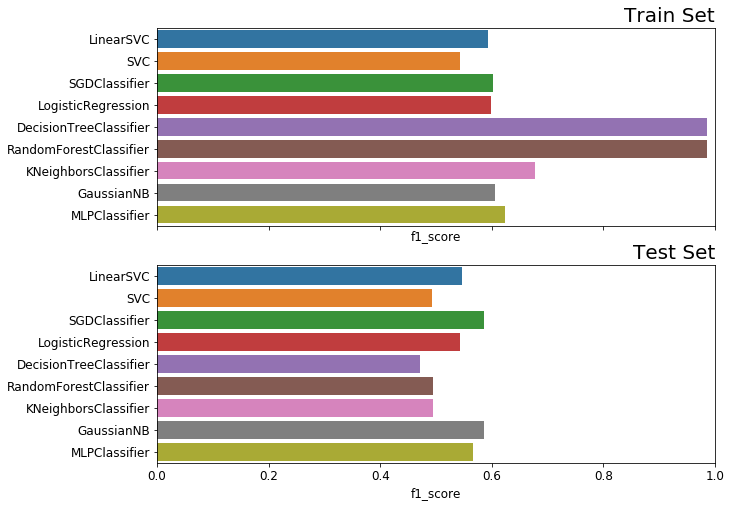

In [47]:
fig, (axes1, axes2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)
sns.barplot(data=df_train, x='f1_score', y=df_train.index, dodge=False, ci=None, ax=axes1)
sns.barplot(data=df_test, x='f1_score', y=df_test.index, dodge=False, ci=None, ax=axes2)
#axes.get_legend().remove()
axes1.set_xlim(0,1)
axes2.set_xlim(0,1)
axes1.set_title('Train Set', loc='right')
axes2.set_title('Test Set', loc='right')
plt.show()

In [48]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

model_names=df_train.index

trace1 = go.Bar(
    x=df_train['f1_score'],
    y=model_names,
    name='Train F1 Score',
    orientation='h'
)
trace2 = go.Bar(
    x=df_test['f1_score'],
    y=model_names,
    name='Test F1 Score',
    orientation='h'
)

data = [trace1, trace2]
layout = go.Layout(
    title='F1 Score : Train vs Test Set',
    barmode='group',
    yaxis=go.layout.YAxis(
        automargin=True
    )
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, image_width=200, image_height=200)

In [34]:
# From a RF or DT, find out the importance of
# each feature, in descending order of score
def extractFeatureImportance(features):
    imp_dict = {}
    
    for name, val in features:
        name0 = name.split('_')[0]
        if name0 in imp_dict:
            imp_dict[name0] = imp_dict[name0] + val
        else:
            imp_dict[name0] = val
    
    imp_dict = sorted(imp_dict.items(), reverse=True, key=lambda x : x[1])
    return imp_dict

### Try out Decision Tree

In [49]:
# GridSearchCV to find optimal parameters on DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'splitter' : ['best', 'random'], 'max_features' : ['auto', 'sqrt', 'log2'],
               'max_depth': [2, 5, 10, 20, None], 'max_leaf_nodes' : [5, 10, 20, None]
              }]

tree_gs_clf = DecisionTreeClassifier()
grid_search = GridSearchCV(tree_gs_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(train_data_encoded_X, train_data_encoded_y.values.ravel())

print("grid_search.best_params_ =", grid_search.best_params_)
print("grid_search.best_score_ =", grid_search.best_score_)
print("grid_search.best_estimator_ =", grid_search.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s


grid_search.best_params_ = {'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'splitter': 'random'}
grid_search.best_score_ = 0.7904302143972739
grid_search.best_estimator_ = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features='sqrt', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   11.8s finished


In [50]:
# List feature importance based on above classifier
estimator = grid_search.best_estimator_
feature_importances = sorted(zip(train_data_encoded_X.columns, estimator.feature_importances_), reverse=True, key=lambda x : x[1])
important_features = extractFeatureImportance(feature_importances)
print("Important features as per Decision Tree:")
important_features

Important features as per Decision Tree:


[('Contract', 0.3686658195431701),
 ('TechSupport', 0.19217462624812984),
 ('tenure', 0.177513483725218),
 ('InternetService', 0.1558461079056405),
 ('PaymentMethod', 0.06937706410317432),
 ('OnlineSecurity', 0.015339113562404154),
 ('OnlineBackup', 0.01329859277175428),
 ('StreamingTV', 0.0077851921405086896),
 ('MonthlyCharges', 0.0)]

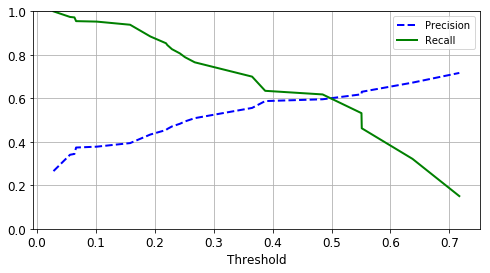

In [51]:
# Plot a precision-recall curve for above classifier
# and find optimal probability threshold for positive target class
from sklearn.metrics import precision_recall_curve

y_pred_proba = estimator.predict_proba(train_data_encoded_X)
precisions, recalls, thresholds = precision_recall_curve(train_data_encoded_y, y_pred_proba[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-1, 1])
plt.grid()
plt.show()

Decision Tree Score: (0.6275591033268406, 0.6185438705662726, 0.5318352059925093, 0.5719217491369389, 0.7066791028029806)


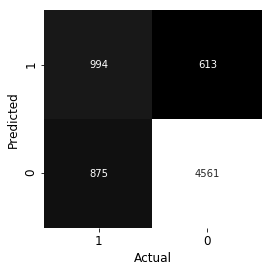

In [52]:
# Find confusion matrix based on above threshold value
print("Decision Tree Score:", checkClassifierModelAccuracy(estimator, train_data_encoded_X, train_data_encoded_y))

proba_threshold = 0.5
y_pred = estimator.predict_proba(train_data_encoded_X)
y_pred = np.where(y_pred[:,1] >= proba_threshold, 1, 0)

conf_matrix = confusion_matrix(train_data_encoded_y, y_pred, labels = [1,0])
norm_conf_matrix = np.sum(conf_matrix, axis=1, keepdims=True)
norm_conf_matrix = conf_matrix/norm_conf_matrix
sns.heatmap(conf_matrix.T, annot=True, fmt="d", square=True, cbar=False, 
            cmap=plt.cm.gray, xticklabels=[1,0], yticklabels=[1,0])
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

Decision Tree Score: (0.6275591033268406, 0.6185438705662726, 0.5318352059925093, 0.5719217491369389, 0.7066791028029806)
Precision = 0.6185438705662726
Recall = 0.5318352059925093
Score = 0.7887263950021298


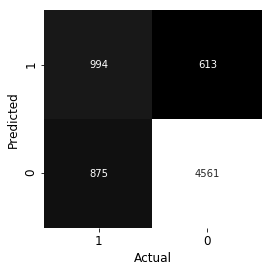

In [53]:
# Plot confusion matrix for optimal classifier
print("Decision Tree Score:", checkClassifierModelAccuracy(estimator, train_data_encoded_X, train_data_encoded_y))

y_pred = estimator.predict(train_data_encoded_X)
print("Precision =", precision_score(train_data_encoded_y, y_pred))
print("Recall =", recall_score(train_data_encoded_y, y_pred, average='binary'))
print("Score =", estimator.score(train_data_encoded_X, train_data_encoded_y))

conf_matrix = confusion_matrix(train_data_encoded_y, y_pred, labels = [1,0])
sns.heatmap(conf_matrix.T, annot=True, fmt="d", square=True, cbar=False, 
            cmap=plt.cm.gray, xticklabels=[1,0], yticklabels=[1,0])
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

### Explore more on Random Forest

In [54]:
# GridSearchCV to find optimal parameters on RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [10, 50, 100, 200, 300], 'max_features' : [None, 'sqrt', 'log2'], 
               'max_depth': [2, 5, 10, 20, None],
               #'oob_score' : ['True', 'False']
              }]

rf_gs_clf = RandomForestClassifier()
grid_search = GridSearchCV(rf_gs_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(train_data_encoded_X, train_data_encoded_y.values.ravel())

print("grid_search.best_params_ =", grid_search.best_params_)
print("grid_search.best_score_ =", grid_search.best_score_)
print("grid_search.best_estimator_ =", grid_search.best_estimator_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  3.4min finished


grid_search.best_params_ = {'max_depth': 5, 'max_features': None, 'n_estimators': 200}
grid_search.best_score_ = 0.7988073264233991
grid_search.best_estimator_ = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [64]:
# Running RF on original data
forest_clf = RandomForestClassifier(max_depth=2, max_features='log2', n_estimators=200, class_weight='balanced')

forest_clf.fit(train_X, train_y)
print("RF on Train with Normal Split:", checkClassifierModelAccuracy(forest_clf, train_X, train_y))
print("RF on Test Normal Split:", checkClassifierModelAccuracy(forest_clf, test_X, test_y))

forest_clf.fit(strat_train_X, strat_train_y)
print("RF on Train with Stratified Split:", checkClassifierModelAccuracy(forest_clf, strat_train_X, strat_train_y))
print("RF on Test Stratified Split:", checkClassifierModelAccuracy(forest_clf, strat_test_X, strat_test_y))

RF on Train with Normal Split: (0.5209816937557346, 0.4768211920529801, 0.8242424242424242, 0.6041461006910168, 0.7502749841144634)
RF on Test Normal Split: (0.522439896417686, 0.5023622047244094, 0.8307291666666666, 0.6261040235525024, 0.7612182418699186)
RF on Train with Stratified Split: (0.5180753826260738, 0.4776923076923077, 0.8307692307692308, 0.6065934065934065, 0.7513353281171595)
RF on Test Stratified Split: (0.5108208863128192, 0.46875, 0.8422459893048129, 0.6022944550669216, 0.7486592265364644)


In [35]:
# List feature importance based on above predictions
feature_importances = sorted(zip(strat_train_X.columns, forest_clf.feature_importances_), reverse=True, key=lambda x : x[1])
important_features = extractFeatureImportance(feature_importances)
print("Important features as per Random Forest:")
important_features

Important features as per Random Forest:


[('Contract', 0.3471073317162715),
 ('TechSupport', 0.15036150455540234),
 ('OnlineSecurity', 0.14710450611247278),
 ('tenure', 0.11478064706623113),
 ('InternetService', 0.07798614923769699),
 ('OnlineBackup', 0.05816077704722312),
 ('PaymentMethod', 0.04728755818669161),
 ('StreamingTV', 0.03808910038471105),
 ('MonthlyCharges', 0.010841152270984589),
 ('PaperlessBilling', 0.006542604591521974),
 ('StreamingMovies', 0.0016415299032469862),
 ('gender', 9.713892754586251e-05),
 ('PhoneService', 0.0)]

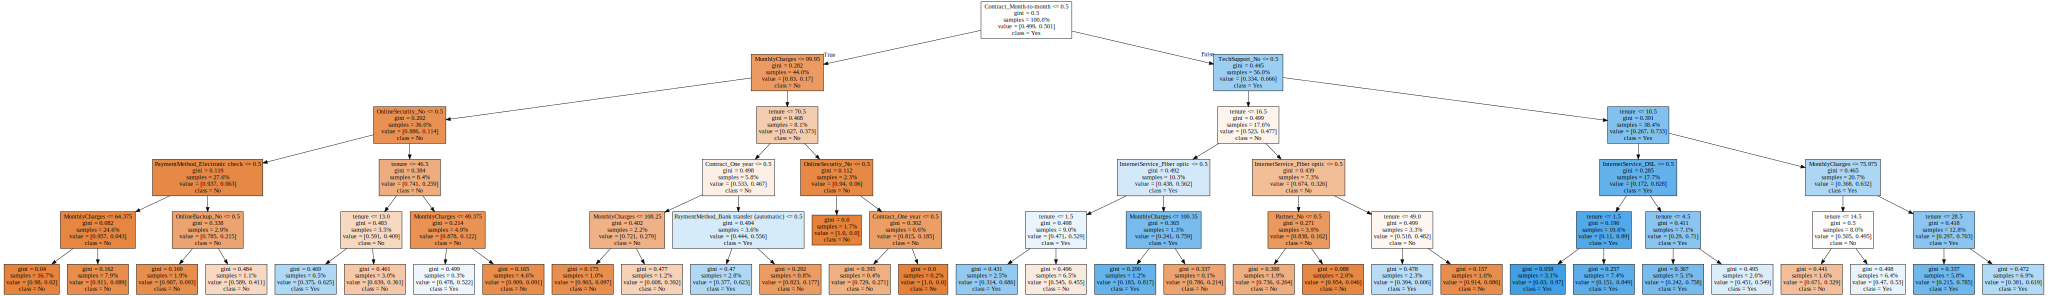

In [27]:
# Plot the decision tree
from IPython.display import SVG
from IPython.display import display
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
import os
os.environ['PATH'] += os.pathsep + r'C:\Softwares_Installed\Anaconda3\pkgs\graphviz-2.38.0-4\Library\bin\graphviz'

estimator = forest_clf.estimators_[1]

graph = Source(tree.export_graphviz(estimator, out_file=None,
                                    feature_names=strat_train_X.columns, class_names=['No','Yes'],
                                    proportion=True, filled = True))

display(SVG(graph.pipe(format='svg')))

### Now trying Gradient Boosting

In [28]:
# GridSearchCV to find optimal parameters on GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid = [{'learning_rate': [0.01, 0.03, 0.1, 0.3], 'max_features': [0.2, 0.5, 0.8, 1.0],
               'loss': ['deviance', 'exponential'], 'max_depth': [2, 5, 10, 20]
              }]

gdb_gs_clf = GradientBoostingClassifier()
grid_search = GridSearchCV(gdb_gs_clf, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')
grid_search.fit(train_data_encoded_X, train_data_encoded_y.values.ravel())

print("grid_search.best_params_ =", grid_search.best_params_)
print("grid_search.best_score_ =", grid_search.best_score_)
print("grid_search.best_estimator_ =", grid_search.best_estimator_)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 16.4min finished


grid_search.best_params_ = {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 0.8}
grid_search.best_score_ = 0.8490748837781542
grid_search.best_estimator_ = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=0.8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


### And Logistic Regression

In [54]:
# GridSearchCV to find optimal parameters on LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = [{'fit_intercept': [True, False],
               #'max_iter': [100, 500, 1000, 5000, 10000],
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'C': [1.0, 0.5, 0.1, 2.0],
              }]

logreg_gs_clf = LogisticRegression(max_iter=500, class_weight='balanced', random_state=1)
grid_search = GridSearchCV(logreg_gs_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(train_data_encoded_X, train_data_encoded_y.values.ravel())

print("grid_search.best_params_ =", grid_search.best_params_)
print("grid_search.best_score_ =", grid_search.best_score_)
print("grid_search.best_estimator_ =", grid_search.best_estimator_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.0min finished


grid_search.best_params_ = {'C': 0.1, 'fit_intercept': True, 'solver': 'lbfgs'}
grid_search.best_score_ = 0.7492545790146244
grid_search.best_estimator_ = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


### Voting Classifier

In [65]:
# Voting classifier ensemble to with multiple classifiers
from sklearn.ensemble import VotingClassifier
svc_clf = SVC(probability=True)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, loss='log')

from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression(C=0.1, fit_intercept=False, solver='newton-cg')

from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(max_depth=5, max_features=None, n_estimators=100)

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)

from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(1000,500,200,100,50,7), max_iter=500, early_stopping=True, random_state=1)

gnb_clf = GaussianNB()

estimators=[('sgd', sgd_clf), ('knn', knn_clf), ('gnb', gnb_clf), ('svc', svc_clf),
            ('logreg', logreg_clf), ('mlp', mlp_clf), ('forest', forest_clf)]
voting_soft_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_soft_clf.fit(strat_train_X, strat_train_y)

print("Soft Voting on Train with Stratified Split:", checkClassifierModelAccuracy(voting_soft_clf, strat_train_X, strat_train_y))
print("Soft Voting on Test Stratified Split:", checkClassifierModelAccuracy(voting_soft_clf, strat_test_X, strat_test_y))

Soft Voting on Train with Stratified Split: (0.6075360321210199, 0.7391874180865007, 0.7545150501672241, 0.746772591857001, 0.8291782788888791)
Soft Voting on Test Stratified Split: (0.6080423879541486, 0.6026315789473684, 0.6122994652406417, 0.6074270557029178, 0.7332028727169392)


### MLP Classifier

In [66]:
# MLP with multiple hidden layers
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(1000,500,200,100,50,7), max_iter=500, early_stopping=True, random_state=1)
mlp_clf.fit(strat_train_X, strat_train_y)

print("MLP on Train with Stratified Split:", checkClassifierModelAccuracy(mlp_clf, strat_train_X, strat_train_y))
print("MLP on Test Stratified Split:", checkClassifierModelAccuracy(mlp_clf, strat_test_X, strat_test_y))

MLP on Train with Stratified Split: (0.624112074252765, 0.6435568952524491, 0.57123745819398, 0.6052445074415309, 0.7284793234434506)
MLP on Test Stratified Split: (0.627020557795093, 0.6439628482972136, 0.5561497326203209, 0.5968436154949784, 0.7225193107546047)


### Drop least important features and try

In [125]:
y_pred = voting_soft_clf.predict(strat_test_X)
sum(y_pred == 1)/len(strat_test_X)

0.27466288147622425